# Exploration of one customer

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import solarhome as sh

In [3]:
df_raw = sh.read_csv('2011-2012')
df, missing_rec = sh.reshape(df_raw)

In [159]:
n_cust = 12
d = df[n_cust]
d.to_csv('customer/12/data_12.csv')
d.head()

Channel,GC,GG
2011-07-01 00:00:00,0.392,0.0
2011-07-01 00:30:00,0.578,0.0
2011-07-01 01:00:00,0.568,0.0
2011-07-01 01:30:00,0.482,0.0
2011-07-01 02:00:00,0.456,0.0


In [158]:
d.describe([])

Channel,GC,GG
count,17568.000000,17568.000000
mean,0.676044,0.147587
std,0.351625,0.227503
min,0.000000,0.000000
50%,0.586000,0.000000
max,4.004000,0.900000


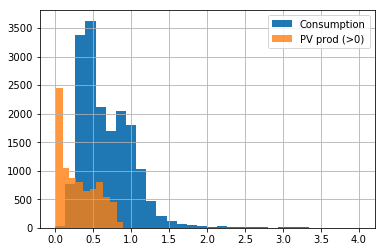

In [30]:
prod = d.GG
cons = d.GC
cons.hist(bins=30, label='Consumption')
(prod[prod>=0.01]).hist(label='PV prod (>0)', alpha=0.8)
plt.legend();

In [90]:
%matplotlib qt5

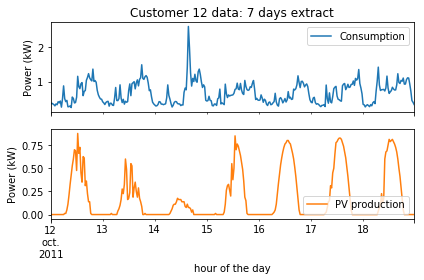

In [171]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

sl = slice('2011-10-12','2011-10-18') # 3 semi-cloudy, 1 very cloudy, 3 sunny days 
#sl=slice(0, -1)
cons[sl].plot(ax=ax1, label='Consumption')
prod[sl].plot(ax=ax2, color='tab:orange', label='PV production')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax1.set(
    title='Customer %d data: 7 days extract' % n_cust,
    ylabel='Power (kW)'
)
ax2.set(
    xlabel='hour of the day',
    ylabel='Power (kW)'
);

fig.tight_layout()
fig.savefig('customer/12/data_7days.png', dpi=200, bbox_inches='tight')

### Daily pattern

In [ ]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

d_dm = d.groupby(by=hod).mean()
d_d05 = d.groupby(by=hod).quantile(.05)
d_d25 = d.groupby(by=hod).quantile(.25)
d_d75 = d.groupby(by=hod).quantile(.75)
d_d95 = d.groupby(by=hod).quantile(.95)

**TODO** : save the pattern (mean + quantiles) to a CSV for later reuse 

In [178]:
daily_pat = pd.DataFrame({
    'mean': d_dm.GG,
    'q05': d_d05.GG
})
daily_pat.head()

,mean,q05
0.0,0.000197,0.0
0.5,0.000033,0.0
1.0,0.000098,0.0
1.5,0.000164,0.0
2.0,0.000262,0.0


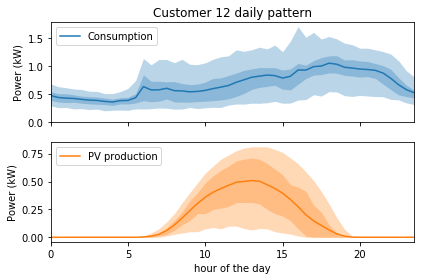

In [172]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

c = 'tab:blue'
d_dm.GC.plot(ax=ax1, color=c, label='Consumption')
ax1.fill_between(d_dm.index, d_d05.GC, d_d95.GC, alpha=0.3, color=c, lw=0)
ax1.fill_between(d_dm.index, d_d25.GC, d_d75.GC, alpha=0.3, color=c, lw=0)
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper left')

c = 'tab:orange'
d_dm.GG.plot(ax=ax2, color=c, label='PV production')
ax2.fill_between(d_dm.index, d_d05.GG, d_d95.GG, alpha=0.3, color=c, lw=0)
ax2.fill_between(d_dm.index, d_d25.GG, d_d75.GG, alpha=0.3, color=c, lw=0)
ax2.legend(loc='upper left')

ax1.set(
    title='Customer %d daily pattern' % n_cust,
    ylabel='Power (kW)'
);
ax2.set(
    xlabel='hour of the day',
    ylabel='Power (kW)'
);
fig.tight_layout()
fig.savefig('customer/12/daily_pattern.png', dpi=200, bbox_inches='tight')

## Day ahead forecast

model: autoregression on the previous half-hour, the previous day, with effect of the hour of the day.

$$ y_k = f(y_{k-1}, y_{k-48}, h)  $$

More precisely, linear autogression, with coefficient being dependant of the hod:

$$ y_k = a_0(h) + a_1(h).y_{k-1} + a_2(h).y_{k-48} $$

In addition, the series of coefficients $a_0(h)$, $a_1(h)$, $a_2(h)$,... may require some smoothing, that is a penalization of their variations. Either absolute variation around average time-indepent coefficients or variation along the day.

### Data preparation

pivot data: one day per row, one hour per column

In [136]:
d1 = d.copy()
d1['date'] = pd.DatetimeIndex(d1.index.date)
d1['hod'] = hod(d1.index)
d1.head()

Channel,GC,GG,date,hod
2011-07-01 00:00:00,0.392,0.0,2011-07-01,0.0
2011-07-01 00:30:00,0.578,0.0,2011-07-01,0.5
2011-07-01 01:00:00,0.568,0.0,2011-07-01,1.0
2011-07-01 01:30:00,0.482,0.0,2011-07-01,1.5
2011-07-01 02:00:00,0.456,0.0,2011-07-01,2.0


In [155]:
prod_daily = d1.pivot('date', 'hod', 'GG')
prod_daily.head()

hod,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,19.0,19.5,20.0,20.5,21.0,21.5,22.0,22.5,23.0,23.5
date,,,,,,,,,,,,,,,,,,,,,
2011-07-01,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2011-07-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012,0.0
2011-07-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2011-07-04,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2011-07-05,0.0,0.0,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0


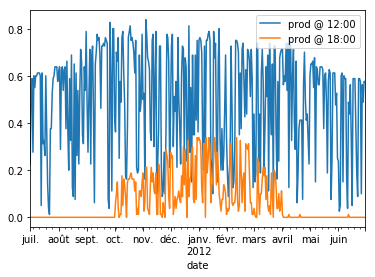

In [147]:
prod_daily[12.0].plot(label='prod @ 12:00')
prod_daily[18.0].plot(label='prod @ 18:00')
plt.legend();

In [150]:
prod_daily.to_csv('customer/12/daily_prod_12.csv')

same pivot for consumption

In [156]:
cons_daily = d1.pivot('date', 'hod', 'GC')
cons_daily.to_csv('customer/12/daily_cons_12.csv')
cons_daily.head()